In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_all_device  = pd.read_excel("./Experimental Data/All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
#print(df_all_device.columns)
df_all_device = df_all_device.iloc[:,2:12]
df_all_device = df_all_device.dropna()
df_all_device.columns = ['Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
        'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']
df_all_device

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%]
0,155,200,5000,1.2,35,50,16.261900,0.932514,0.39,5.914137
1,160,225,3000,0.8,30,75,2.239204,0.108900,0.25,0.060982
2,135,200,2500,1.0,25,75,23.176100,0.926920,0.60,12.889485
3,150,175,2000,1.0,20,100,20.804760,0.739500,0.31,4.769839
4,170,275,4500,1.2,16,50,21.509520,0.832600,0.66,11.820590
...,...,...,...,...,...,...,...,...,...,...
139,170,300,2500,1.0,25,100,15.171420,0.721700,0.39,4.270196
140,160,100,4000,1.0,25,75,15.428570,0.951900,0.49,7.196364
141,155,275,2500,1.2,35,100,5.652380,0.643600,0.43,1.564446
142,140,225,3000,1.0,20,50,21.495230,0.917800,0.72,14.204410


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

X=df_all_device.iloc[:,:6]
y=df_all_device['Efficiency [%]']

X=X.to_numpy(dtype='float')
y=y.to_numpy(dtype='float').reshape(-1,1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

scaler_y = StandardScaler()
scaler_y.fit(y)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)
y = scaler_y.transform(y)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(10,200,10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(2,20,2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# learning_rate 
learning_rate = np.arange(0.025,0.150,0.025)
# subsample 
subsample = np.arange(0.60, 0.95, 0.05) 
# 'reg_alpha':        
alpha = [1e-4, 1e-2, 0.1, 0.5, 0.99]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample,
               'alpha': alpha}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, 
                               n_iter = 1000, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train, y_train)
best_params = gb_random.best_params_


In [5]:
#print(gb_random.best_params_)
best_params = {'subsample': 0.95, 
               'n_estimators': 105, 
               'min_samples_split': 2, 
               'min_samples_leaf': 2, 
               'max_features': 'sqrt',
               'max_depth': 4, 
               'learning_rate': 0.075,
               'alpha':0.99
               }

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
GBregressor_list = []
y_pred_list = []
y_train_pred_list = []
y_test_pred_list = []
for i in np.arange(100):
    GBregressor = GradientBoostingRegressor()
    GBregressor.set_params(**best_params)
    #GBregressor.fit(X_train, y_train.ravel())
    GBregressor.fit(X, y.ravel())

    GBregressor_list.append(GBregressor)
    
    y_train_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_train).reshape(-1,1))
    y_test_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_test).reshape(-1,1))
    y_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X).reshape(-1,1))
    y_train_pred_list.append(y_train_pred)
    y_test_pred_list.append(y_test_pred)
    y_pred_list.append(y_pred)
y_pred_mean = np.mean(y_pred_list, axis = 0)
y_train_pred_mean = np.mean(y_train_pred_list, axis = 0)
y_test_pred_mean = np.mean(y_test_pred_list, axis = 0)


train rmse: 0.9619
test rmse: 1.2816
all rmse: 1.0347
train R^2: 0.9529
test R^2: 0.8871
all R^2: 0.9433
train spearman: 0.9415
test spearman: 0.8650
all spearman: 0.9315


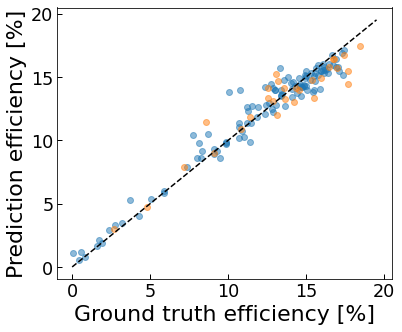

In [7]:
y_train_pred = y_train_pred_mean
y_test_pred = y_test_pred_mean
y_pred = y_pred_mean

from sklearn.metrics import mean_squared_error
mse = mean_squared_error
mse_train = mse(y_train_pred,scaler_y.inverse_transform(y_train))
mse_test = mse(y_test_pred,scaler_y.inverse_transform(y_test))
mse_all = mse(y_pred,scaler_y.inverse_transform(y))
print ('train rmse: %.4f' % (np.sqrt(mse_train)))
print ('test rmse: %.4f' % (np.sqrt(mse_test)))
print ('all rmse: %.4f' % (np.sqrt(mse_all)))


rsquared_train = r2_score(scaler_y.inverse_transform(y_train),y_train_pred)
rsquared_test = r2_score(scaler_y.inverse_transform(y_test), y_test_pred)
rsquared_all = r2_score(scaler_y.inverse_transform(y), y_pred)
print ('train R^2: %.4f' % (rsquared_train))
print ('test R^2: %.4f' % (rsquared_test))
print ('all R^2: %.4f' % (rsquared_all))

sprman_train = spearmanr(y_train_pred,scaler_y.inverse_transform(y_train))
sprman_test = spearmanr(y_test_pred,scaler_y.inverse_transform(y_test))
sprman_all = spearmanr(y_pred,scaler_y.inverse_transform(y))
print ('train spearman: %.4f' % (sprman_train[0]))
print ('test spearman: %.4f' % (sprman_test[0]))
print ('all spearman: %.4f' % (sprman_all[0]))

fs = 22
plt.figure(figsize=(6, 5))
plt.scatter(scaler_y.inverse_transform(y_train),y_train_pred, alpha =0.5)
plt.scatter(scaler_y.inverse_transform(y_test),y_test_pred, alpha =0.5)
#plt.scatter(y_scaled,y_pred, alpha =0.5)
yref = np.arange(0, 20, 0.5)
plt.plot(yref, yref, '--',color='black')
plt.xlabel('Ground truth efficiency [%]', fontsize = fs)
plt.ylabel('Prediction efficiency [%]', fontsize = fs)
plt.xticks([0, 5, 10, 15, 20])
#plt.title("Gradient Boosting")
plt.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
#plt.savefig("Pervoskite Opt for Scale-up/Prelim_data_analysis/data_plots/RFR"+str(X1.name[:4])+".png",dpi=300)
plt.show()

In [8]:
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

temp_min, temp_max, temp_step = [125, 175, 5] ## Unit: degC ## 11 steps
temp_var = np.arange(temp_min, temp_max+temp_step, temp_step)
temp_num = len(temp_var)

speed_min, speed_max, speed_step = [100, 300, 25] ## Unit: mm/s ## 9 steps
speed_var = np.arange(speed_min, speed_max+speed_step, speed_step)
speed_num = len(speed_var)

sprayFL_min, sprayFL_max, sprayFL_step = [2000, 5000, 500] ## Unit: uL/min ## 7 steps
sprayFL_var = np.arange(sprayFL_min, sprayFL_max+sprayFL_step, sprayFL_step) 
sprayFL_num = len(sprayFL_var)

gasFL_min, gasFL_max, gasFL_step = [15, 35, 5] ## Unit: L/min ## 5 steps
gasFL_var = np.arange(gasFL_min, gasFL_max+gasFL_step, gasFL_step)
gasFL_num = len(gasFL_var)

plasmaDC_min, plasmaDC_max, plasmaDC_step = [25, 100, 25] # Unit: [%] ## 4 steps
plasmaDC_var = np.arange(plasmaDC_min, plasmaDC_max+plasmaDC_step, plasmaDC_step)
plasmaDC_num = len(plasmaDC_var)

plasmaH_min, plasmaH_max, plasmaH_step = [0.8, 1.2, 0.2] # Unit: cm ## 3 steps
plasmaH_var = np.arange(plasmaH_min, plasmaH_max+plasmaH_step, plasmaH_step)
plasmaH_num = len(plasmaH_var)


var_array = [temp_var, speed_var, 
             sprayFL_var, plasmaH_var, 
             gasFL_var, plasmaDC_var]
x_labels = ['Temperature [\N{DEGREE SIGN}C]', 
            'Speed [mm/s]',
            'Spray Flow [uL/min]', 
            'Plamsa Height [cm]', 
            'Plasma Gas Flow [L/min]', 
            'Plasma DC [%]']

In [9]:
def x_normalizer(X):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])  
    return np.array(x_norm)

def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
    return np.array(x_original)



def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [10]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace([ContinuousParameter('temp', 0-1/(temp_num-1)/2, 1+1/(temp_num-1)/2),
                                 ContinuousParameter('speed', 0-1/(speed_num-1)/2, 1+1/(speed_num-1)/2),
                                 ContinuousParameter('sprayFL', 0-1/(sprayFL_num-1)/2, 1+1/(sprayFL_num-1)/2),
                                 ContinuousParameter('plamsaH', 0-1/(plasmaH_num-1)/2, 1+1/(plasmaH_num-1)/2),
                                 ContinuousParameter('gasFL', 0-1/(gasFL_num-1)/2, 1+1/(gasFL_num-1)/2),
                                 ContinuousParameter('plasmaDC', 0-1/(plasmaDC_num-1)/2, 1+1/(plasmaDC_num-1)/2)
                                 ])


parameter_space = ParameterSpace([ContinuousParameter('temp', 0,1),
                                 ContinuousParameter('speed', 0,1),
                                 ContinuousParameter('sprayFL', 0,1),
                                 ContinuousParameter('plamsaH', 0,1),
                                 ContinuousParameter('gasFL', 0,1),
                                 ContinuousParameter('plasmaDC', 0,1)
                                 ])

In [12]:
df_thiswork  = pd.read_excel("./All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
df_thiswork = df_thiswork.iloc[:99,0:13]
thiswork_device = df_thiswork['Film Success or not?'] == 'Yes'

In [13]:
y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(X[:99][thiswork_device])
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)

y_pred_thiswork_device = scaler_y.inverse_transform(y_hat_mean)
df_thiswork_device = df_thiswork.iloc[:99,2:8][thiswork_device].copy()
df_thiswork_device = df_thiswork_device.dropna()

max(y_pred_thiswork_device)
df_thiswork_device['Efficiency [%]'] = np.around(y_pred_thiswork_device,2)
df_thiswork_device.iloc[np.argmax(y_pred_thiswork_device):np.argmax(y_pred_thiswork_device)+1]
df_thiswork_device[df_thiswork_device['Efficiency [%]']>16]


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
70,140,200,4000,0.80,20,50,16.74
79,144,166,3270,1.15,19,44,17.10
82,149,170,3160,1.00,20,35,16.45
85,149,148,3120,1.00,18,37,16.91
89,141,134,3050,1.20,20,48,16.39
91,141,174,3010,1.00,16,42,16.38
95,140,150,3500,1.00,20,50,16.74


the rate of top 1 perc (>15%): 0.34


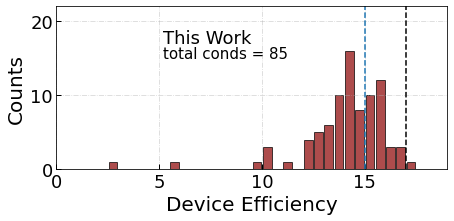

In [14]:
print("the rate of top 1 perc (>15%):", np.around (np.sum(df_thiswork_device.iloc[:,-1]>=15.04)/85, 2))
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
axes.hist(df_thiswork_device.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####
axes.text(5.2, 17, 'This Work', fontsize=fs*0.9)
axes.text(5.2, 15, 'total conds = '+str(len(df_thiswork_device)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, 22)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, 22, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, 22, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [15]:
df_thiswork

,ML Condition,Sample,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%],Film Success or not?
0,0,B29R_3-FR0.dat,155,200,5000,1.2,35,50,16.261900,0.932514,0.39,5.914137,Yes
1,1,I3R,160,225,3000,0.8,30,75,2.239204,0.108900,0.25,0.060982,No
2,2,B18RPALE_4-FR0.dat,135,200,2500,1.0,25,75,23.176100,0.926920,0.60,12.889485,Yes
3,3,I2R,150,175,2000,1.0,20,100,20.804760,0.739500,0.31,4.769839,No
4,4,I6R,170,275,4500,1.2,16,50,21.509520,0.832600,0.66,11.820590,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,F7R.dat,140,150,3500,1.2,20,50,19.786000,1.021000,0.79,15.959000,Yes
95,96,F6R.dat,140,150,3500,1.0,20,50,18.933000,0.978000,0.58,10.739000,Yes
96,97,F24R.dat,145,125,3000,1.2,16,50,22.752000,0.987000,0.74,16.621000,Yes
97,98,F42L.dat,150,175,3500,1.0,16,50,26.433000,0.978000,0.58,14.988000,Yes


### Full Factorial

In [16]:
x_grid = []
for x1 in np.linspace(0, 1, temp_num):#int((temp_num-1)/2+1)): 
    for x2 in np.linspace(0, 1, speed_num):
        for x3 in np.linspace(0, 1, sprayFL_num):
            for x4 in np.linspace(0, 1, plasmaH_num):
                for x5 in np.linspace(0, 1, gasFL_num):
                    for x6 in np.linspace(0, 1, plasmaDC_num):
                        x_grid.append([x1,x2,x3,x4,x5,x6])

x_grid_original = x_denormalizer(x_grid)
df_fullgrid = pd.DataFrame(x_grid_original, columns = x_labels)
df_fullgrid

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)


y_pred_grid = scaler_y.inverse_transform(y_hat_mean)
max(y_pred_grid)
df_fullgrid['Efficiency [%]'] = np.around(y_pred_grid, 2)
df_fullgrid.iloc[np.argmax(y_pred_grid):np.argmax(y_pred_grid)+1]

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
15700,145.0,125.0,3000.0,1.2,15.0,25.0,17.13


max:  17.13
min:  -3.35
top 1 perc:  15.280000000000001
mean efficiency:  8.871667388167388


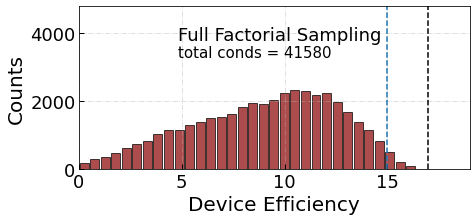

In [17]:
print('max: ', np.max(df_fullgrid.iloc[:,-1].values))
print('min: ', np.min(df_fullgrid.iloc[:,-1].values))

print('top 1 perc: ', np.quantile(df_fullgrid.iloc[:,-1].values, 0.99))
print('mean efficiency: ', np.mean(df_fullgrid.iloc[:,-1].values))


fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_fullgrid.iloc[:,-1], bins= 40, range = (0, 20.5), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####
axes.text(4.8, 3800, 'Full Factorial Sampling', fontsize=fs*0.9)
axes.text(4.8, 3300, 'total conds = '+str(len(df_fullgrid)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, 4800)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, 5000, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, 5000, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

### Iterative Partial Grid Sampling

- Partial Factorial DoE - 2-level 

In [21]:
x_bd = np.array([[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1]])
step = 1
n_level = 2
x_grid=[]
x_opt_lastround = []
for n in np.arange(7):

    for x1 in np.linspace(x_bd[0][0], x_bd[0][1], n_level): 
        for x2 in np.linspace(x_bd[1][0], x_bd[1][1], n_level):
            for x3 in np.linspace(x_bd[2][0], x_bd[2][1], n_level):
                for x4 in np.linspace(x_bd[3][0], x_bd[3][1], n_level):
                    for x5 in np.linspace(x_bd[4][0], x_bd[4][1], n_level):
                        for x6 in np.linspace(x_bd[5][0], x_bd[5][1], n_level):
                            x_grid.append([x1,x2,x3,x4,x5,x6])

    x_grid_original = x_denormalizer(x_grid)
    df_grid = pd.DataFrame(x_grid_original, columns = x_labels)

    y_hat_list = []
    for i in np.arange(len(GBregressor_list)):
        y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
        y_hat_list.append(y_hat)
    y_hat_mean = np.mean(y_hat_list, axis = 0)
    y_pred_grid = scaler_y.inverse_transform(y_hat_mean)                        
    df_grid['Efficiency [%]'] = np.around(y_pred_grid, 2)
    df_grid = df_grid.drop_duplicates(keep = 'last', ignore_index = True)                        
    x_opt = x_normalizer([df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values)].values[:-1]])[0]
    
    print(x_opt)                        
    print('num, eff[%]:',len(df_grid),max(df_grid['Efficiency [%]'].values))
    print('step:',step)
    if step<= 0.5 and np.sum(x_opt != x_opt_lastround) == 6:
         step = step*2
    elif step >= 0.01:
         step = step/2
    
    #step = step/2
    x_new_bd = [] 
    for indx in np.arange(len(x_opt)):
        xi = x_opt[indx]
        if abs(xi - x_bd[indx][0])<= 1e-4:
            x_new_bd.append(np.sort([xi, abs(xi-step)]))
        if abs(xi - x_bd[indx][1])<= 1e-4:
            x_new_bd.append(np.sort([1-abs(xi+step-1), xi]))
        
    x_bd = np.array(x_new_bd)
    print(x_bd)
    #print(len(x_bd))
    x_opt_lastround = x_opt
    
pGrid_list1 = df_grid['Efficiency [%]'].values


[0. 0. 0. 1. 0. 0.]
num, eff[%]: 64 11.68
step: 1
[[0.  0.5]
 [0.  0.5]
 [0.  0.5]
 [0.5 1. ]
 [0.  0.5]
 [0.  0.5]]
[0.5 0.5 0.5 1.  0.  0. ]
num, eff[%]: 127 14.48
step: 0.5
[[0.5  0.75]
 [0.5  0.75]
 [0.5  0.75]
 [0.75 1.  ]
 [0.   0.25]
 [0.   0.25]]
[0.5  0.5  0.5  0.75 0.   0.  ]
num, eff[%]: 190 14.53
step: 0.25
[[0.375 0.5  ]
 [0.375 0.5  ]
 [0.375 0.5  ]
 [0.625 0.75 ]
 [0.    0.125]
 [0.    0.125]]
[0.375 0.375 0.5   0.625 0.    0.   ]
num, eff[%]: 253 17.1
step: 0.125
[[0.3125 0.375 ]
 [0.3125 0.375 ]
 [0.5    0.5625]
 [0.5625 0.625 ]
 [0.     0.0625]
 [0.     0.0625]]
[0.375  0.375  0.5    0.625  0.     0.0625]
num, eff[%]: 316 17.37
step: 0.0625
[[0.375   0.40625]
 [0.375   0.40625]
 [0.46875 0.5    ]
 [0.625   0.65625]
 [0.      0.03125]
 [0.0625  0.09375]]
[0.40625 0.375   0.46875 0.65625 0.      0.0625 ]
num, eff[%]: 379 17.67
step: 0.03125
[[0.40625  0.421875]
 [0.359375 0.375   ]
 [0.453125 0.46875 ]
 [0.65625  0.671875]
 [0.       0.015625]
 [0.046875 0.0625  ]]
[0.4

In [23]:
x_bd = np.array([[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1]])
step = 1
n_level = 2
x_grid=[]
x_opt_lastround = []
batch_num = []
for n in np.arange(7):

    for x1 in np.linspace(x_bd[0][0], x_bd[0][1], n_level): 
        for x2 in np.linspace(x_bd[1][0], x_bd[1][1], n_level):
            for x3 in np.linspace(x_bd[2][0], x_bd[2][1], n_level):
                for x4 in np.linspace(x_bd[3][0], x_bd[3][1], n_level):
                    for x5 in np.linspace(x_bd[4][0], x_bd[4][1], n_level):
                        for x6 in np.linspace(x_bd[5][0], x_bd[5][1], n_level):
                            x_grid.append([x1,x2,x3,x4,x5,x6])

    x_grid_original = x_denormalizer(x_grid)
    df_grid = pd.DataFrame(x_grid_original, columns = x_labels)

    y_hat_list = []
    for i in np.arange(len(GBregressor_list)):
        y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
        y_hat_list.append(y_hat)
    y_hat_mean = np.mean(y_hat_list, axis = 0)
    y_pred_grid = scaler_y.inverse_transform(y_hat_mean)                        
    df_grid['Efficiency [%]'] = np.around(y_pred_grid, 2)
    df_grid = df_grid.drop_duplicates(keep = 'last', ignore_index = True)                        
    x_opt = x_normalizer([df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values)].values[:-1]])[0]
    
    print(x_opt)                        
    print('num, eff[%]:',len(df_grid),max(df_grid['Efficiency [%]'].values))
    batch_num.append(len(df_grid))
    print('step:',step)
    if step<= 0.5 and np.sum(x_opt != x_opt_lastround) == 6:
         step = step*2
    elif step >= 0.01:
         step = step/2
    
    #step = step/2
    x_new_bd = [] 
    for indx in np.arange(len(x_opt)):
        xi = x_opt[indx]
        if abs(xi - x_bd[indx][0])<= 1e-4:
            x_new_bd.append(np.sort([xi,1-abs(xi+step-1)]))
        if abs(xi - x_bd[indx][1])<= 1e-4:
            x_new_bd.append(np.sort([abs(xi-step), xi]))
        
    x_bd = np.array(x_new_bd)
    print(x_bd)
    #print(len(x_bd))
    x_opt_lastround = x_opt
    
pGrid_list2 = df_grid['Efficiency [%]'].values


[0. 0. 0. 1. 0. 0.]
num, eff[%]: 64 11.68
step: 1
[[0.  0.5]
 [0.  0.5]
 [0.  0.5]
 [0.5 1. ]
 [0.  0.5]
 [0.  0.5]]
[0.5 0.5 0.5 1.  0.  0. ]
num, eff[%]: 127 14.48
step: 0.5
[[0.25 0.5 ]
 [0.25 0.5 ]
 [0.25 0.5 ]
 [0.75 1.  ]
 [0.   0.25]
 [0.   0.25]]
[0.25 0.25 0.5  1.   0.   0.  ]
num, eff[%]: 190 16.14
step: 0.25
[[0.25  0.375]
 [0.25  0.375]
 [0.375 0.5  ]
 [0.875 1.   ]
 [0.    0.125]
 [0.    0.125]]
[0.375 0.375 0.5   1.    0.    0.   ]
num, eff[%]: 253 17.04
step: 0.125
[[0.3125 0.375 ]
 [0.3125 0.375 ]
 [0.4375 0.5   ]
 [0.9375 1.    ]
 [0.     0.0625]
 [0.     0.0625]]
[0.375  0.375  0.4375 1.     0.     0.0625]
num, eff[%]: 316 17.6
step: 0.0625
[[0.34375 0.375  ]
 [0.34375 0.375  ]
 [0.4375  0.46875]
 [0.96875 1.     ]
 [0.      0.03125]
 [0.03125 0.0625 ]]
[0.375  0.375  0.4375 1.     0.0625 0.0625]
num, eff[%]: 379 17.6
step: 0.03125
[[0.359375 0.375   ]
 [0.359375 0.375   ]
 [0.4375   0.453125]
 [0.984375 1.      ]
 [0.046875 0.0625  ]]


IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
import random
pGrid_list = []
for n in np.arange(100):
    pGrid_temp = pGrid_list1.copy()
    random.shuffle(pGrid_temp[:batch_num[0]])

    for i_num in np.arange(len(batch_num)-1):
        random.shuffle(pGrid_temp[batch_num[i_num]:batch_num[i_num+1]])
        #print(batch_num[i_num],batch_num[i_num+1])

    pGrid_list.append(pGrid_temp)
    

In [ ]:
max_eff = 17.7
#pGrid_list = [pGrid_list1, pGrid_list2]
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
i = 0
eff_max_runlist = []
for df_i in pGrid_list:
    eff_max_acc = np.maximum.accumulate(df_i)
    eff_acc = df_i
    i = i +1
    ax.plot(range(len(eff_max_acc)),eff_max_acc/max_eff, alpha = 0.8*i/len(pGrid_list)+0.4, c = 'gray', linewidth=2)
    eff_max_runlist.append(eff_max_acc/max_eff)

line_95perc = np.percentile(eff_max_runlist, 95, axis = 0)
line_median = np.percentile(eff_max_runlist, 50, axis = 0)
line_5perc = np.percentile(eff_max_runlist, 5, axis = 0)

ax.plot(line_95perc,'--', c = 'black', linewidth=1.5)
ax.plot(line_5perc,'--', c = 'black', linewidth=1.5)
ax.plot(line_median,'-', c = 'black', linewidth=2)

#axes.text(80, 9, 'One Var at at Time', fontsize=fs*0.9)
#axes.text(80, 8, 'total conds = '+str(len(convglen_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(8/max_eff,18/max_eff)
axes.set_xlim(0,300)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Normalized PCE [a.u.]', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
axes.set_title('Subdivitive Partial Grid 1', fontsize = fs)
plt.show()



In [ ]:
import random
pGrid_list = []
for n in np.arange(50):
    pGrid_temp = pGrid_list1.copy()
    random.shuffle(pGrid_temp[:batch_num[0]])
    for i_num in np.arange(len(batch_num)-1):
        random.shuffle(pGrid_temp[batch_num[i_num]:batch_num[i_num+1]])
    pGrid_list.append(pGrid_temp)
    
    pGrid_temp = pGrid_list2.copy()
    random.shuffle(pGrid_temp[:batch_num[0]])
    for i_num in np.arange(len(batch_num)-1):
        random.shuffle(pGrid_temp[batch_num[i_num]:batch_num[i_num+1]])
    pGrid_list.append(pGrid_temp)

In [ ]:
max_eff = 17.7
#pGrid_list = [pGrid_list1, pGrid_list2]
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
i = 0
eff_max_runlist = []
for df_i in pGrid_list:
    eff_max_acc = np.maximum.accumulate(df_i)
    eff_acc = df_i
    i = i +1
    ax.plot(range(len(eff_max_acc)),eff_max_acc/max_eff, alpha = 0.8*i/len(pGrid_list)+0.4, c = 'gray', linewidth=0.75)
    eff_max_runlist.append(eff_max_acc/max_eff)

line_95perc = np.percentile(eff_max_runlist, 95, axis = 0)
line_median = np.percentile(eff_max_runlist, 50, axis = 0)
line_5perc = np.percentile(eff_max_runlist, 5, axis = 0)

ax.plot(line_95perc,'--', c = 'black', linewidth=1.5)
ax.plot(line_5perc,'--', c = 'black', linewidth=1.5)
ax.plot(line_median,'-', c = 'black', linewidth=2)

#axes.text(80, 9, 'One Var at at Time', fontsize=fs*0.9)
#axes.text(80, 8, 'total conds = '+str(len(convglen_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(8/max_eff,18/max_eff)
axes.set_xlim(0,300)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Normalized PCE [a.u.]', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
axes.set_title('Iterative Partial Grid 2', fontsize = fs)
plt.show()



In [ ]:
x_grid = []
n_level = 2
for x1 in np.linspace(0, 1, n_level): 
    for x2 in np.linspace(0, 1, n_level):
        for x3 in np.linspace(0, 1, n_level):
            for x4 in np.linspace(0, 1, n_level):
                for x5 in np.linspace(0, 1, n_level):
                    for x6 in np.linspace(0, 1, n_level):
                        x_grid.append([x1,x2,x3,x4,x5,x6])

x_grid_original = x_denormalizer(x_grid)
df_grid = pd.DataFrame(x_grid_original, columns = x_labels)

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)
y_pred_grid = scaler_y.inverse_transform(y_hat_mean)

df_grid['Efficiency [%]'] = np.around(y_pred_grid, 2)
df_grid = df_grid.drop_duplicates(keep = 'last', ignore_index = True)

fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_grid.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####

axes.text(8.2, max(hist_data[0])*.9, 'Grid Search', fontsize=fs*0.9)
axes.text(8.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_grid)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, max(hist_data[0])*1.1)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()



In [ ]:
print(x_normalizer([df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values)].values[:-1]]))
df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values):np.argmax(df_grid['Efficiency [%]'].values)+1]


In [ ]:
#x_grid = []
n_level = 2
for x1 in np.linspace(0, 0.5, n_level): 
    for x2 in np.linspace(0, 0.5, n_level):
        for x3 in np.linspace(0, 0.5, n_level):
            for x4 in np.linspace(0, 0.5, n_level):
                for x5 in np.linspace(0, 0.5, n_level):
                    for x6 in np.linspace(0, 0.5, n_level):
                        x_grid.append([x1,x2,x3,x4,x5,x6])

x_grid_original = x_denormalizer(x_grid)
df_grid = pd.DataFrame(x_grid_original, columns = x_labels)

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)
y_pred_grid = scaler_y.inverse_transform(y_hat_mean)

max(y_pred_grid)
df_grid['Efficiency [%]'] = np.around(y_pred_grid, 2)
df_grid = df_grid.drop_duplicates(keep = 'last', ignore_index = True)

fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_grid.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####

axes.text(5.2, max(hist_data[0])*.9, 'Grid Search', fontsize=fs*0.9)
axes.text(5.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_grid)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, max(hist_data[0])*1.1)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [ ]:
print(x_normalizer([df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values)].values[:-1]]))
df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values):np.argmax(df_grid['Efficiency [%]'].values)+1]


In [ ]:
#x_grid = []
n_level = 2
for x1 in np.linspace(0, 0.25, n_level): 
    for x2 in np.linspace(0.25, 0.5, n_level):
        for x3 in np.linspace(0.25, 0.5, n_level):
            for x4 in np.linspace(0.5, 0.75, n_level):
                for x5 in np.linspace(0.25, 0.5, n_level):
                    for x6 in np.linspace(0.25, 0.5, n_level):
                        x_grid.append([x1,x2,x3,x4,x5,x6])

x_grid_original = x_denormalizer(x_grid)
df_grid = pd.DataFrame(x_grid_original, columns = x_labels)

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)
y_pred_grid = scaler_y.inverse_transform(y_hat_mean)

df_grid['Efficiency [%]'] = np.around(y_pred_grid, 2)
df_grid = df_grid.drop_duplicates(keep = 'last', ignore_index = True)

fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_grid.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####

axes.text(5.2, max(hist_data[0])*.9, 'Grid Search', fontsize=fs*0.9)
axes.text(5.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_grid)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, max(hist_data[0])*1.1)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [196]:
print(x_normalizer([df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values)].values[:-1]]))
df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values):np.argmax(df_grid['Efficiency [%]'].values)+1]


[[0.25 0.25 0.5  0.75 0.25 0.25]]


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
170,137.5,150.0,3500.0,1.1,20.0,43.75,15.0


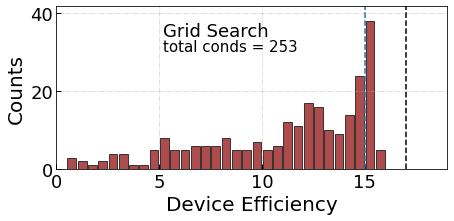

In [197]:
#x_grid = []
n_level = 2

for x1 in np.linspace(0.25, 0.375, n_level): 
    for x2 in np.linspace(0.125, 0.25, n_level):
        for x3 in np.linspace(0.5, 0.625, n_level):
            for x4 in np.linspace(0.75, 0.875, n_level):
                for x5 in np.linspace(0.125, 0.25, n_level):
                    for x6 in np.linspace(0.125, 0.25, n_level):
                        x_grid.append([x1,x2,x3,x4,x5,x6])

x_grid_original = x_denormalizer(x_grid)
df_grid = pd.DataFrame(x_grid_original, columns = x_labels)

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)
y_pred_grid = scaler_y.inverse_transform(y_hat_mean)

df_grid['Efficiency [%]'] = np.around(y_pred_grid, 2)
df_grid = df_grid.drop_duplicates(keep = 'last', ignore_index = True)

fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_grid.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####

axes.text(5.2, max(hist_data[0])*.9, 'Grid Search', fontsize=fs*0.9)
axes.text(5.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_grid)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, max(hist_data[0])*1.1)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [198]:
print(x_normalizer([df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values)].values[:-1]]))
df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values):np.argmax(df_grid['Efficiency [%]'].values)+1]


[[0.375 0.25  0.625 0.75  0.125 0.125]]


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
245,143.75,150.0,3875.0,1.1,17.5,34.375,15.76


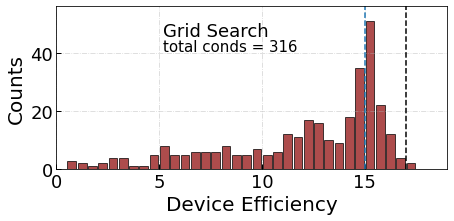

In [199]:
#x_grid = []
n_level = 2

for x1 in np.linspace(0.375, 0.5, n_level): 
    for x2 in np.linspace(0.25, 0.375, n_level):
        for x3 in np.linspace(0.625, 0.75, n_level):
            for x4 in np.linspace(0.625, 0.75, n_level):
                for x5 in np.linspace(0.0, 0.125, n_level):
                    for x6 in np.linspace(0.0, 0.125, n_level):
                        x_grid.append([x1,x2,x3,x4,x5,x6])

x_grid_original = x_denormalizer(x_grid)
df_grid = pd.DataFrame(x_grid_original, columns = x_labels)

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)
y_pred_grid = scaler_y.inverse_transform(y_hat_mean)

df_grid['Efficiency [%]'] = np.around(y_pred_grid, 2)
df_grid = df_grid.drop_duplicates(keep = 'last', ignore_index = True)


fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_grid.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####

axes.text(5.2, max(hist_data[0])*.9, 'Grid Search', fontsize=fs*0.9)
axes.text(5.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_grid)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, max(hist_data[0])*1.1)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [200]:
print(x_normalizer([df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values)].values[:-1]]))
df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values):np.argmax(df_grid['Efficiency [%]'].values)+1]


[[0.375 0.375 0.625 0.625 0.    0.   ]]


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
268,143.75,175.0,3875.0,1.05,15.0,25.0,17.09


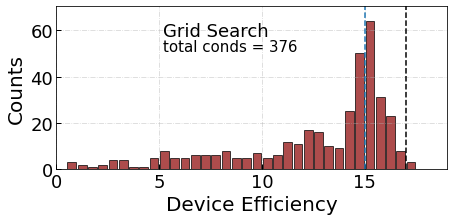

In [201]:
#x_grid = []
n_level = 2

for x1 in np.linspace(0.25, 0.375, n_level): 
    for x2 in np.linspace(0.375, 0.5, n_level):
        for x3 in np.linspace(0.5, 0.625, n_level):
            for x4 in np.linspace(0.5, 0.625, n_level):
                for x5 in np.linspace(0.0, 0.125, n_level):
                    for x6 in np.linspace(0, 0.125, n_level):
                        x_grid.append([x1,x2,x3,x4,x5,x6])

x_grid_original = x_denormalizer(x_grid)
df_grid = pd.DataFrame(x_grid_original, columns = x_labels)

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)
y_pred_grid = scaler_y.inverse_transform(y_hat_mean)

df_grid['Efficiency [%]'] = np.around(y_pred_grid, 2)
df_grid = df_grid.drop_duplicates(keep = 'last', ignore_index = True)


fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_grid.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####

axes.text(5.2, max(hist_data[0])*.9, 'Grid Search', fontsize=fs*0.9)
axes.text(5.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_grid)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, max(hist_data[0])*1.1)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [202]:
print(x_normalizer([df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values)].values[:-1]]))
df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values):np.argmax(df_grid['Efficiency [%]'].values)+1]


[[0.375 0.375 0.625 0.625 0.    0.   ]]


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
356,143.75,175.0,3875.0,1.05,15.0,25.0,17.09


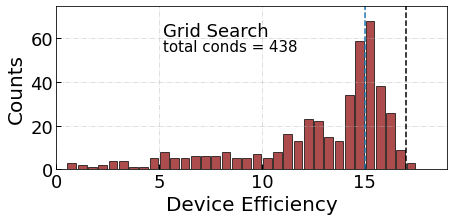

In [203]:
#x_grid = []
n_level = 2

for x1 in np.linspace(0.375, 0.625, n_level): 
    for x2 in np.linspace(0.125, 0.375, n_level):
        for x3 in np.linspace(0.625, 0.875, n_level):
            for x4 in np.linspace(0.625, 0.875, n_level):
                for x5 in np.linspace(0, 0.25, n_level):
                    for x6 in np.linspace(0.0, 0.25, n_level):
                        x_grid.append([x1,x2,x3,x4,x5,x6])

x_grid_original = x_denormalizer(x_grid)
df_grid = pd.DataFrame(x_grid_original, columns = x_labels)

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)
y_pred_grid = scaler_y.inverse_transform(y_hat_mean)

df_grid['Efficiency [%]'] = np.around(y_pred_grid, 2)
df_grid = df_grid.drop_duplicates(keep = 'last', ignore_index = True)


fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_grid.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####

axes.text(5.2, max(hist_data[0])*.9, 'Grid Search', fontsize=fs*0.9)
axes.text(5.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_grid)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, max(hist_data[0])*1.1)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [204]:
print(x_normalizer([df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values)].values[:-1]]))
df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values):np.argmax(df_grid['Efficiency [%]'].values)+1]


[[0.375 0.375 0.625 0.625 0.    0.   ]]


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
390,143.75,175.0,3875.0,1.05,15.0,25.0,17.09


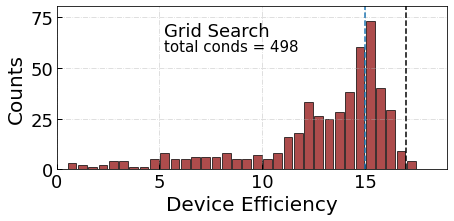

In [205]:
#x_grid = []
n_level = 2

for x1 in np.linspace(0.0, 0.375, n_level): 
    for x2 in np.linspace(0.375, 0.625, n_level):
        for x3 in np.linspace(0.375, 0.625, n_level):
            for x4 in np.linspace(0.375, 0.625, n_level):
                for x5 in np.linspace(0, 0.25, n_level):
                    for x6 in np.linspace(0, 0.25, n_level):
                        x_grid.append([x1,x2,x3,x4,x5,x6])

x_grid_original = x_denormalizer(x_grid)
df_grid = pd.DataFrame(x_grid_original, columns = x_labels)

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)
y_pred_grid = scaler_y.inverse_transform(y_hat_mean)

df_grid['Efficiency [%]'] = np.around(y_pred_grid, 2)
df_grid = df_grid.drop_duplicates(keep = 'last', ignore_index = True)

fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_grid.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####

axes.text(5.2, max(hist_data[0])*.9, 'Grid Search', fontsize=fs*0.9)
axes.text(5.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_grid)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, max(hist_data[0])*1.1)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [206]:
print(x_normalizer([df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values)].values[:-1]]))
df_grid.iloc[np.argmax(df_grid['Efficiency [%]'].values):np.argmax(df_grid['Efficiency [%]'].values)+1]

[[0.375 0.375 0.625 0.625 0.    0.   ]]


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
478,143.75,175.0,3875.0,1.05,15.0,25.0,17.09


In [207]:
df_grid 

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
0,125.00,100.0,2000.0,0.80,15.0,100.00,7.85
1,125.00,100.0,2000.0,0.80,35.0,25.00,4.26
2,125.00,100.0,2000.0,0.80,35.0,100.00,4.55
3,125.00,100.0,2000.0,1.20,15.0,25.00,11.74
4,125.00,100.0,2000.0,1.20,15.0,100.00,9.52
...,...,...,...,...,...,...,...
493,143.75,225.0,3875.0,0.95,20.0,43.75,13.65
494,143.75,225.0,3875.0,1.05,15.0,25.00,14.26
495,143.75,225.0,3875.0,1.05,15.0,43.75,14.26
496,143.75,225.0,3875.0,1.05,20.0,25.00,13.53
